In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("youtube_analytics_cleaned.csv")
df.head()


,title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,PT1M51S,hd,False,0.106375,0.099928,0.006448,111,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,PT1M,hd,True,0.012059,0.009652,0.002407,60,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,PT18M2S,hd,False,0.015129,0.013593,0.001535,1082,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,PT3M23S,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,PT3M35S,hd,True,0.077768,0.069856,0.007912,215,0


In [7]:
df.info()
df.describe()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    537 non-null    object 
 1   channel_title            537 non-null    object 
 2   published_at             537 non-null    object 
 3   category_id              537 non-null    int64  
 4   view_count               537 non-null    int64  
 5   like_count               537 non-null    int64  
 6   comment_count            537 non-null    int64  
 7   favorite_count           537 non-null    int64  
 8   duration                 537 non-null    object 
 9   definition               537 non-null    object 
 10  caption                  537 non-null    bool   
 11  engagement_rate          537 non-null    float64
 12  likes_to_views_ratio     537 non-null    float64
 13  comments_to_views_ratio  537 non-null    float64
 14  duration_seconds         5

title                      0
channel_title              0
published_at               0
category_id                0
view_count                 0
like_count                 0
comment_count              0
favorite_count             0
duration                   0
definition                 0
caption                    0
engagement_rate            0
likes_to_views_ratio       0
comments_to_views_ratio    0
duration_seconds           0
video_age_days             0
dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_110316\2207280909.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  views_over_time = df.groupby(df['published_at'].dt.to_period('M'))['view_count'].sum()


<Axes: title={'center': 'Monthly Views Trend'}, xlabel='published_at'>

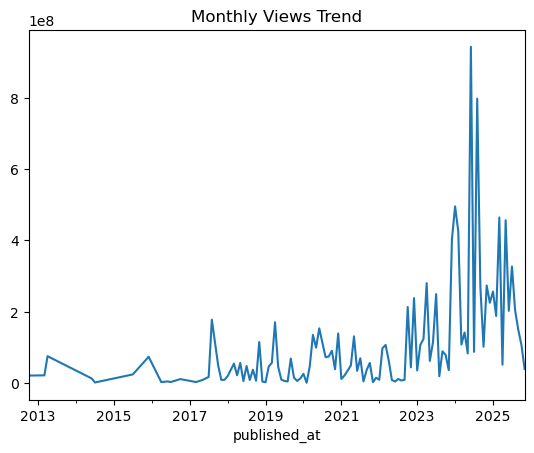

In [8]:
df['published_at'] = pd.to_datetime(df['published_at'])
df = df.sort_values('published_at')

views_over_time = df.groupby(df['published_at'].dt.to_period('M'))['view_count'].sum()
views_over_time.plot(kind='line', title='Monthly Views Trend')


Text(0.5, 1.0, 'Engagement Rate vs Views')

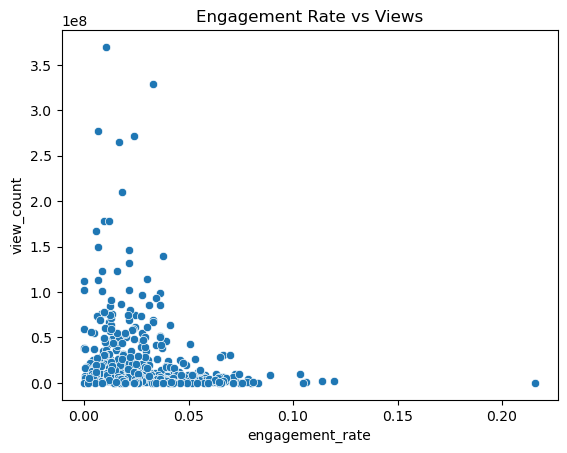

In [9]:
sns.scatterplot(
    x='engagement_rate',
    y='view_count',
    data=df
)
plt.title('Engagement Rate vs Views')


Text(0.5, 1.0, 'Video Duration vs Views')

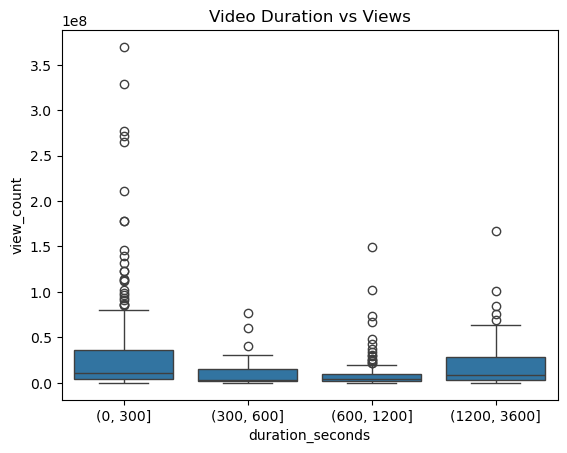

In [10]:
sns.boxplot(
    x=pd.cut(df['duration_seconds'], bins=[0,300,600,1200,3600]),
    y='view_count',
    data=df
)
plt.title('Video Duration vs Views')


<Axes: title={'center': 'Avg Views by Category'}, xlabel='category_id'>

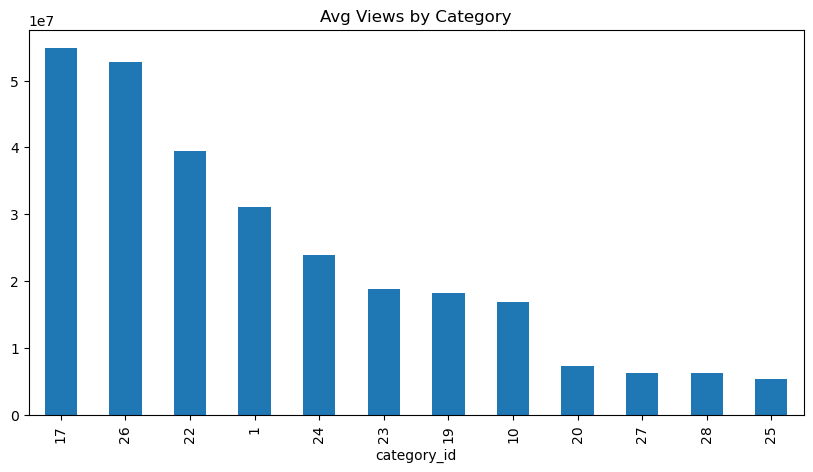

In [11]:
category_views = df.groupby('category_id')['view_count'].mean().sort_values(ascending=False)

category_views.plot(kind='bar', figsize=(10,5), title='Avg Views by Category')


In [24]:
df['log_views'] = np.log1p(df['view_count'])

df['video_age_bucket'] = pd.cut(
    df['video_age_days'],
    bins=[0,7,30,90,180,365,2000]
)

df['high_definition'] = df['definition'].map({'hd':1, 'sd':0})

df['caption_available'] = df['caption'].map({'true':1, 'false':0})


In [13]:
features = [
    'like_count',
    'comment_count',
    'engagement_rate',
    'duration_seconds',
    'video_age_days',
    'high_definition',
    'caption_available'
]


In [25]:
# Import the train_test_split function from sklearn
from sklearn.model_selection import train_test_split

X = df[features]
y = df['log_views']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((429, 7), (108, 7))

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [27]:
from sklearn.metrics import mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, pred_rf))
print("R2:", r2_score(y_test, pred_rf))

MAE: 0.136065464571847
R2: 0.9864415212730131


<Axes: title={'center': 'Feature Importance'}>

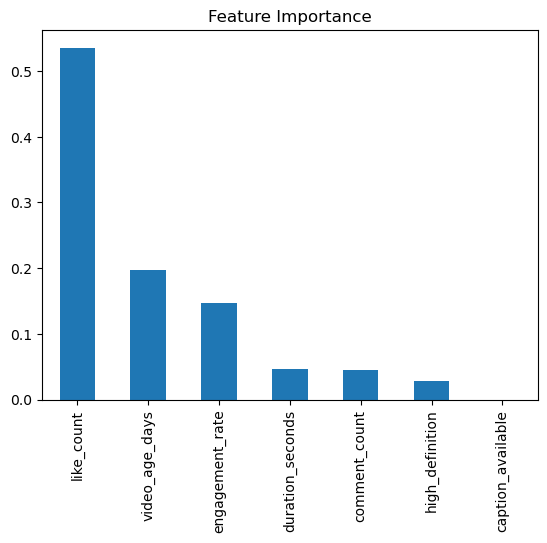

In [30]:
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.plot(kind='bar', title='Feature Importance')


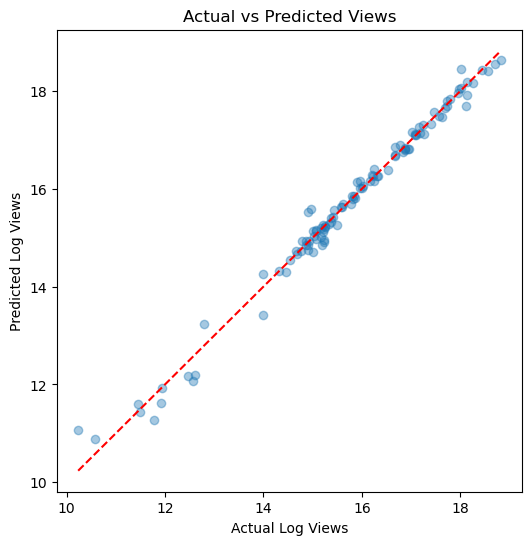

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_rf, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Log Views")
plt.ylabel("Predicted Log Views")
plt.title("Actual vs Predicted Views")
plt.show()


In [34]:
predicted_views = np.expm1(pred_rf)
actual_views = np.expm1(y_test)
pd.DataFrame({
    'Actual Views': actual_views[:10],
    'Predicted Views': predicted_views[:10]
})

,Actual Views,Predicted Views
39,130717.0,7.910727e+04
504,4235246.0,4.036012e+06
164,1647329.0,1.661659e+06
341,84806548.0,7.737375e+07
280,4148571.0,2.984566e+06
288,149137658.0,1.240920e+08
468,4029086.0,3.675770e+06
2,1189857.0,6.741657e+05
359,36212162.0,3.317916e+07
209,4739137.0,4.458153e+06


In [35]:
sample_video = pd.DataFrame([{
    'like_count': 2000,
    'comment_count': 150,
    'engagement_rate': 0.08,
    'duration_seconds': 600,
    'video_age_days': 30,
    'high_definition': 1,
    'caption_available': 1
}])

log_pred = rf.predict(sample_video)
predicted_views = int(np.expm1(log_pred)[0])

predicted_views


377751

In [36]:
import joblib

joblib.dump(rf, 'youtube_channel_view_prediction_model.pkl')


['youtube_channel_view_prediction_model.pkl']